In [45]:
# Data Cleaning

In [46]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import requests
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType

from pyspark.ml.feature import VectorAssembler,StringIndexer
from pyspark.ml.regression import LinearRegression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import calendar
import os
from math import radians, cos, sin, asin, sqrt

In [48]:
# Download Training dataset file.

URL = "https://www.dropbox.com/s/cem9ea35wllfsqg/train.csv?dl=1"
response = requests.get(URL)
open("train.csv", "wb").write(response.content)

200589097

In [49]:
# Download Testing dataset file.

URL = "https://www.dropbox.com/s/hrqzwaihgeibx4x/test.csv?dl=1"
response = requests.get(URL)
open("test.csv", "wb").write(response.content)

70794289

In [50]:
spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()
df = spark.read.csv("./train.csv", header=True)
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: string (nullable = true)



In [51]:
df.show()

+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016-01-19 12:

In [52]:
# Check for NaN or null values

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
| id|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|  0|        0|              0|               0|              0|               0|              0|                0|               0|                 0|            0|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+



In [53]:
# Removing id from `id` column.

df = df.withColumn("id", expr("replace(id, 'id', '')"))

In [54]:
# Covert Datatype of the dataframe.

df = df.withColumn("id",df.id.cast('int'))
df = df.withColumn("vendor_id", df.vendor_id.cast('int'))
df = df.withColumn("pickup_datetime", to_timestamp(df.pickup_datetime, "yyyy-MM-dd HH:mm:ss"))
df = df.withColumn("dropoff_datetime", to_timestamp(df.dropoff_datetime, "yyyy-MM-dd HH:mm:ss"))
df = df.withColumn("passenger_count",df.passenger_count.cast('int'))
df = df.withColumn("pickup_longitude",df.pickup_longitude.cast('float'))
df = df.withColumn("pickup_latitude",df.pickup_latitude.cast('float'))
df = df.withColumn("dropoff_longitude",df.dropoff_longitude.cast('float'))
df = df.withColumn("dropoff_latitude",df.dropoff_latitude.cast('float'))
df = df.withColumn('store_and_fwd_flag', F.when(df.store_and_fwd_flag == 'N', 0).otherwise(1))
df = df.withColumn("trip_duration",df.trip_duration.cast('int'))

In [55]:
# Check for columns data types

for col in df.dtypes:
    print(col[0]+" , "+col[1])

id , int
vendor_id , int
pickup_datetime , timestamp
dropoff_datetime , timestamp
passenger_count , int
pickup_longitude , float
pickup_latitude , float
dropoff_longitude , float
dropoff_latitude , float
store_and_fwd_flag , int
trip_duration , int


In [56]:
# Calculate difference in dropoff and pickup time

df = df.withColumn('diff_in_dropff_and_pickup',df["dropoff_datetime"].cast("double") - df['pickup_datetime'].cast("double"))

In [57]:
# Calculate the difference between trip duration and the difference of the pickup and dropoff time

df = df.withColumn('diff_in_trip_duration_and_manual_calc_time',df["trip_duration"].cast("double") - df['diff_in_dropff_and_pickup'].cast("double"))

In [58]:
# Checking for unique values in `diff_in_trip_duration_and_manual_calc_time`

df.select('diff_in_trip_duration_and_manual_calc_time').distinct().collect()

[Row(diff_in_trip_duration_and_manual_calc_time=0.0)]

In [59]:
# Checking if trip duration is 0 or negative, if there then we can remove it.

df.filter(df.trip_duration <= 0).count()

0

In [60]:
# Checking for unique values in `store_and_fwd_flag`

df.select('store_and_fwd_flag').distinct().collect()

[Row(store_and_fwd_flag=1), Row(store_and_fwd_flag=0)]

In [61]:
# Calculate distance between two latitute and longtitude.

def distance(pickUpLat1, dropOffLat2, pickUpLon1, dropOffLon2):
    longitude = radians(dropOffLon2) - radians(pickUpLon1)
    x = sin(longitude / 2)**2 + cos(radians(pickUpLat1)) * cos(radians(dropOffLat2)) * sin(longitude / 2)**2
 
    temp = 2 * asin(sqrt(x))
    earth_radius = 6371
    return(temp * earth_radius)

In [62]:
# Calculating distance between pickup and dropoff latitude and longtitude.

udf_func = udf(distance, FloatType())
df = df.withColumn("distance", udf_func(df.pickup_latitude, df.dropoff_latitude, df.pickup_longitude, df.dropoff_longitude))

In [63]:
# distance is in K.M.

df.select("distance").show()

+----------+
|  distance|
+----------+
| 2.4444735|
| 2.6599078|
|  3.669969|
| 0.3108382|
|0.01808935|
| 1.2867697|
| 1.6197599|
|  6.528439|
| 1.9105701|
| 1.1227313|
| 2.7310188|
| 4.8806133|
| 2.9884133|
| 1.3675101|
| 2.4467576|
|0.94180226|
| 1.1335393|
| 0.7535885|
| 3.4582636|
| 1.0207591|
+----------+
only showing top 20 rows



In [64]:
# Only keep records where distance between non overlapped points

print("Count unique values Before filtering for distance < 0 is ", df.count()) 
df = df.filter(df.distance > 0)

Count unique values Before filtering for distance < 0 is  1458644


In [65]:
# Counting total number of unique values in dataframe.

df.count()

1452028

In [66]:
if os.path.isdir('train-cleaned') == False:
    df.coalesce(1).write.csv("train-cleaned", header=True)

# Data Visualization

In [67]:
for col in df.dtypes:
    print(col[0]+" , "+col[1])

id , int
vendor_id , int
pickup_datetime , timestamp
dropoff_datetime , timestamp
passenger_count , int
pickup_longitude , float
pickup_latitude , float
dropoff_longitude , float
dropoff_latitude , float
store_and_fwd_flag , int
trip_duration , int
diff_in_dropff_and_pickup , double
diff_in_trip_duration_and_manual_calc_time , double
distance , float


In [68]:
# Now start creating plots

distance = df.toPandas()['distance'].values;
trip_duration = df.toPandas()['trip_duration'].values;

Text(0, 0.5, 'time')

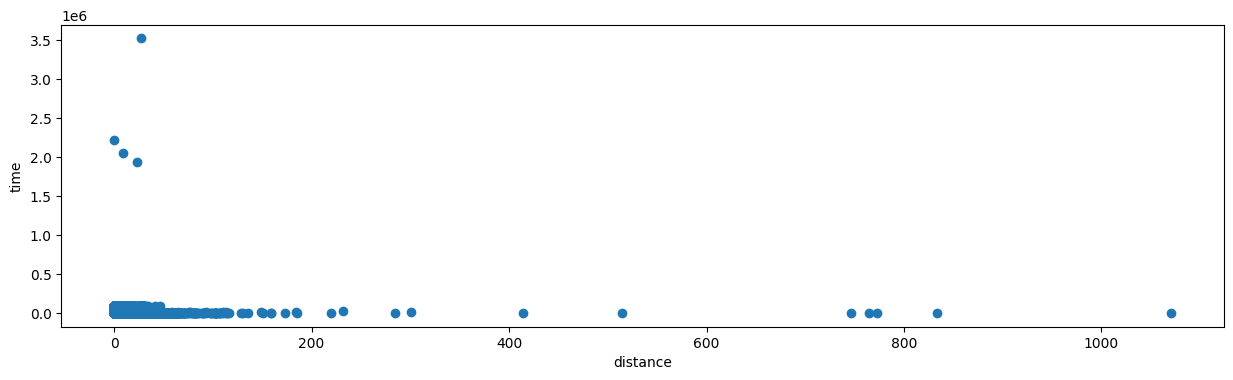

In [69]:
figure(figsize=(15, 4), dpi=100)


plt.scatter(distance, trip_duration)
plt.xlabel("distance")
plt.ylabel("time")

In [70]:
#df.agg({'distance': 'min'}).show()
#df.agg({'distance': 'max'}).show()
#df.agg({'distance': 'avg'}).show()
#df.agg({'trip_duration': 'min'}).show()
#df.agg({'trip_duration': 'max'}).show()
#df.agg({'trip_duration': 'avg'}).show()

# distance:  min: 4.2417497E-4   max: 1240.9087   avg: 3.45
# time:   min: 1    max:  3526282   average: 961  0.500000

Text(0, 0.5, 'log time')

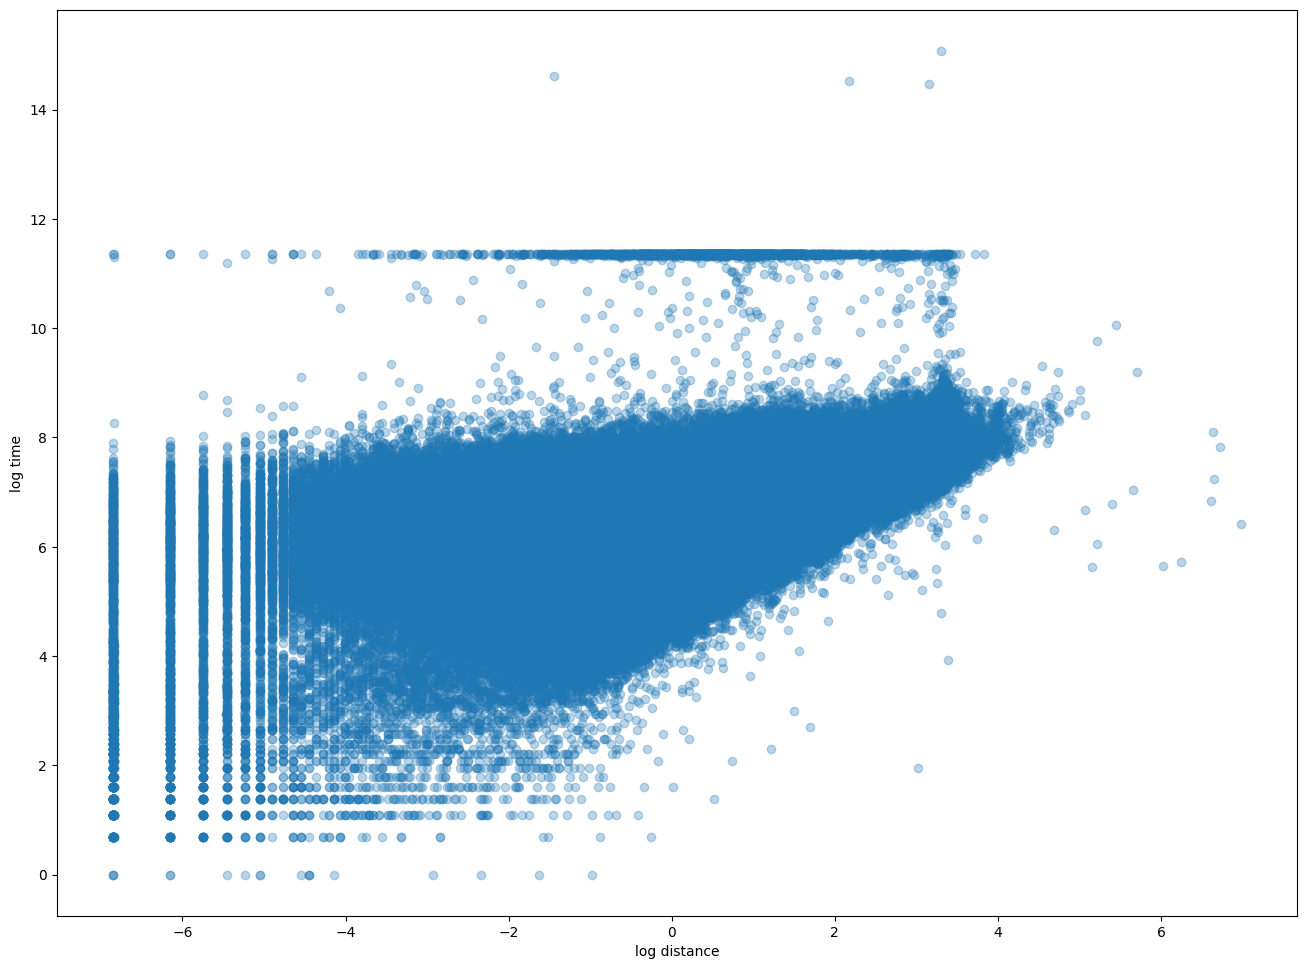

In [71]:
figure(figsize=(16, 12), dpi=100)
plt.scatter(np.log(distance), np.log(trip_duration), alpha=0.3)
plt.xlabel("log distance")
plt.ylabel("log time")

In [72]:
# To remove the outliers, make sure time < 500000. Actually, make sure time is less than 3 hours
# to remove the outliers, make sure distance < 200
# 10800 seconds = 3 hours
df_filtered = df.filter((df.trip_duration < 10800) & (df.distance < 200))

distance_filtered = df_filtered.toPandas()['distance']
trip_duration_filtered = df_filtered.toPandas()['trip_duration']

Text(0, 0.5, 'time')

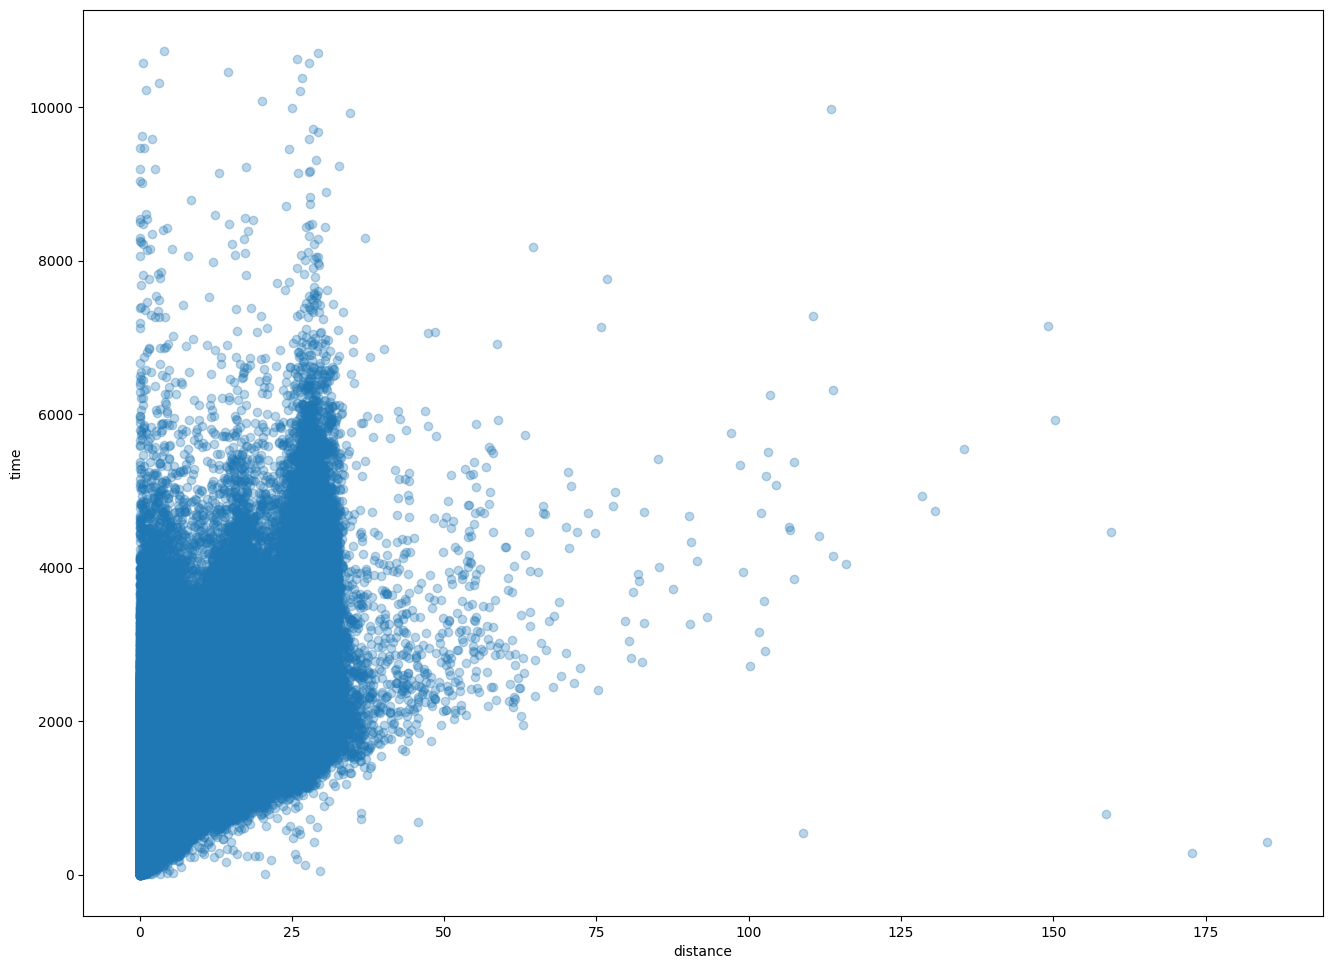

In [73]:
figure(figsize=(16, 12), dpi=100)
plt.scatter(distance_filtered, trip_duration_filtered, alpha=0.3)
plt.xlabel("distance")
plt.ylabel("time")

#plt.scatter(distance,trip_duration, 'o', ms=14, markerfacecolor="None",markeredgecolor='red', markeredgewidth=5)

Text(0, 0.5, 'time')

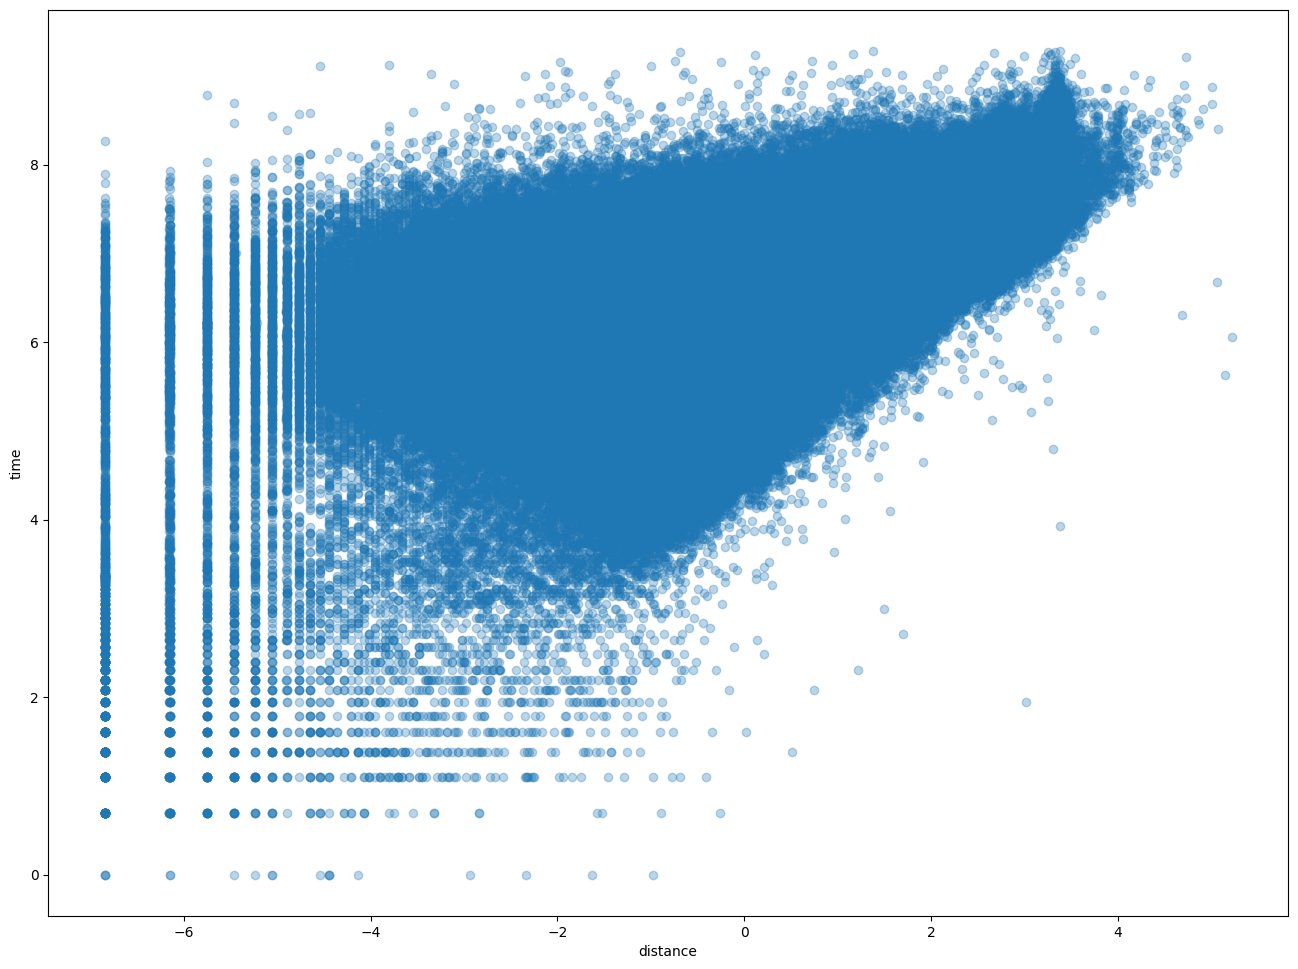

In [74]:
figure(figsize=(16, 12), dpi=100)
plt.scatter(np.log(distance_filtered), np.log(trip_duration_filtered), alpha=0.3)
plt.xlabel("distance")
plt.ylabel("time")

In [75]:
# Now get mean trip duration for each day of the week

df_day = df.select(df["pickup_datetime"], df["trip_duration"], df["distance"])
df_day = df_day.withColumn('day_name', date_format(df["pickup_datetime"], "E"))

df_avg_time = df_day.groupBy("day_name").mean("trip_duration")

df_avg_time.show()

+--------+------------------+
|day_name|avg(trip_duration)|
+--------+------------------+
|     Sun| 903.5534951171725|
|     Mon| 899.5865896337901|
|     Thu|1009.0720398970399|
|     Sat| 950.2920859841474|
|     Wed|  977.250365696257|
|     Tue| 985.6849446062985|
|     Fri| 991.7176962315453|
+--------+------------------+



Text(0, 0.5, 'Mean Duration')

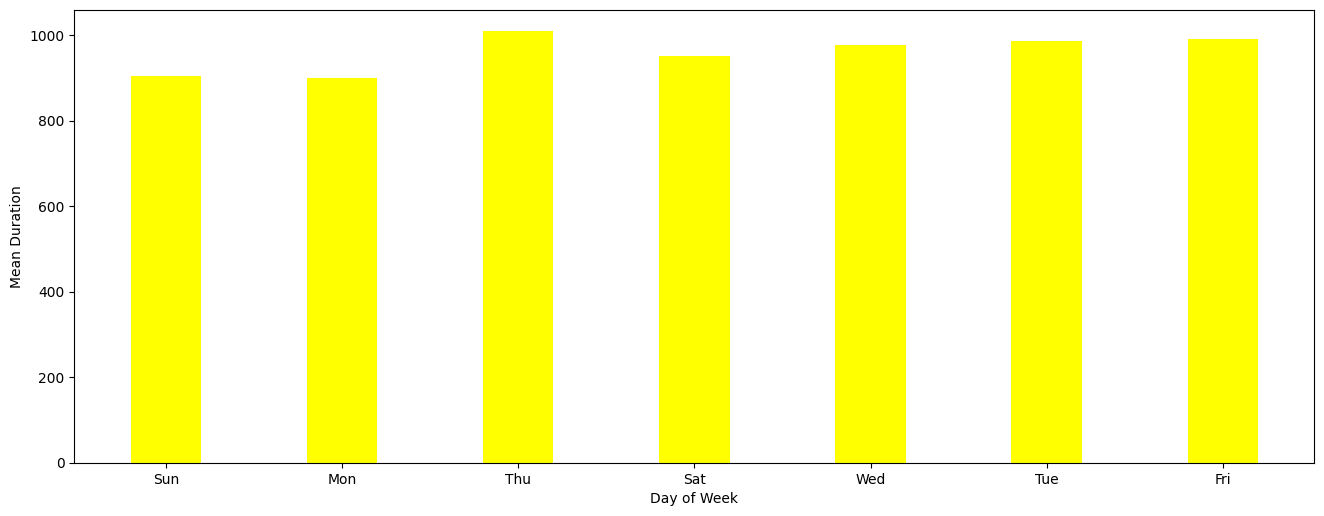

In [76]:
figure(figsize=(16, 6), dpi=100)
x = df_avg_time.toPandas()['day_name'].values;
y = df_avg_time.toPandas()['avg(trip_duration)'].values
plt.bar(x, y, color ='yellow',width = 0.4)
plt.xlabel('Day of Week')
plt.ylabel('Mean Duration')


Ideas:

    Some kind of a heatmap
    Scatterplot of distance over duration
    Weekday-weekend plot of distance over duration
    Average trip duration for each day of the week
    Average distance on sunday and number (average, total) of trips on sunday
    

Things that need to be done:

    Approximate distance between geographic coordinates in meters
    Why do we have negative distance?



# Linear Regression Model

In [77]:
# Remove all trips that have trip_duration more than 50000 seconds which is equivalent to more than 14 hours and less than 10 seconds.
# Remove all trips which total distance is less than 0.5 and more than 200 KM because NYC is not big than 200 KM.

df_trip_duration_filter = df.filter(df.trip_duration < 50000)
df_trip_duration_filter = df_trip_duration_filter.filter(df_trip_duration_filter.trip_duration > 10)

df_lr = df_trip_duration_filter.filter(df_trip_duration_filter.distance > 0.5)
df_lr = df_lr.filter(df_lr.distance < 200)

In [78]:
# Converting pickup and dropoff time to unix time.

df_lr = df_lr.withColumn("pickup_datetime", unix_timestamp("pickup_datetime", "yyyy-MM-dd HH:mm:ss"))
df_lr = df_lr.withColumn("dropoff_datetime", unix_timestamp("dropoff_datetime", "yyyy-MM-dd HH:mm:ss"))

In [79]:
# Spliting data into train and test data.

train, test = df_lr.randomSplit(weights=[0.8,0.2], seed=200)

# remove unnecessary features.
cols = ("id","vendor_id", "diff_in_trip_duration_and_manual_calc_time","diff_in_dropff_and_pickup")
train = train.drop(*cols)
test = test.drop(*cols)

# create a feature vector for training dataset.
feature_train = VectorAssembler().setInputCols(['dropoff_datetime', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'store_and_fwd_flag', 'distance']).setOutputCol("vectorized_features")
feature_train_df = feature_train.transform(train)

# create a feature vector for testing dataset.
feature_test = VectorAssembler().setInputCols(['dropoff_datetime', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'store_and_fwd_flag', 'distance']).setOutputCol("vectorized_features")
feature_train_df = feature_test.transform(test)

# creating linear regression model.
linear_regression_model = LinearRegression(featuresCol = 'vectorized_features', labelCol = 'trip_duration', maxIter=100, solver="normal", epsilon=20)
model = linear_regression_model.fit(feature_train_df)


In [80]:
summary = model.summary
print("Root Mean Square Error: %f" % summary.rootMeanSquaredError)
print("Coefficient of Determination(Accuracy): ", summary.r2*100, "%")

Root Mean Square Error: 261.493284
Coefficient of Determination(Accuracy):  85.94134447526744 %
